## 0. Import Libraries

For ease of use and ram, run each stationarities in different sessions

In [2]:
import climextremes
import sys 
import time

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime

import warnings
warnings.simplefilter('ignore')

## 1. Options

In [3]:
# change these
season = 'DJF' # DJF, JJA,
indice_type = 'pers_perc' # others: intensity, freq_perc, freq_abs, pers_perc, pers_abs

# -----
time_resample = 1 # options: 1, 3, 6 (resampling)
wet_hours = 0.1 #mm

# bias algorithm
bias_algo = 'QDM_era5land'

indice_name_dict = {
    'intensity': fr'rx{time_resample}hr',
    'freq_perc': fr'R{time_resample}hr0.95P',
    'freq_abs': fr'R{time_resample}hr{wet_hours}mm',
    'pers_perc': fr'M{time_resample}hrCW0.95P',
    'pers_abs': fr'M{time_resample}hrCW{wet_hours}mm',
}

indice_name = indice_name_dict[indice_type]

# path for resampling information
if time_resample != 1:
    path_resample = fr'{time_resample}hrsum'
else:
    path_resample = fr'{time_resample}hr'
    
# general data path
path_general = fr'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data'

# variable name
name_variable_cosmo = 'TOT_PREC'

# saving path (saving with cosmo var name for both era5 and cosmo)
path_save = fr'{path_general}/data/{name_variable_cosmo}/'

### 1.1 Functions

In [4]:
def prepare_xarray_to_gev(data):
    
    # stack data
    dt_test = data.stack(horizontal = ('rlat', 'rlon'))
    
    # xr to pd df
    dt_test_pd = pd.DataFrame(dt_test.values).dropna(axis=1)
    
    # find no-nan grids
    nonan_grids = dt_test_pd.columns.values
    
    return dt_test, dt_test_pd, nonan_grids

def delete_last_lines(num_grid, grid): 
    
    # display setting
    if not num_grid - grid == 1:
        clear_output(wait=True)
        
def fit_stationary_gev_model(data, grid, return_period):
    """
    Returns:
    location, scale, shape, return_value, neg_log_likelihood
    
    """
    
    gev_data = data.loc[:,grid].values
    
    # scale gev data
    gev_data_reshape = gev_data.reshape(-1, 1)
    gev_data_reshape_fit = MinMaxScaler().fit(gev_data_reshape)
    gev_data_reshape = gev_data_reshape_fit.transform(gev_data_reshape)
    gev_data_reshape = gev_data_reshape.ravel()
    #return gev_data_reshape
    
    # fit gev model
    stationary_model = climextremes.fit_gev(y=gev_data_reshape,
                                           returnPeriod = return_period,
                                           getParams = True,
                                           getFit = True,
                                           #optimArgs = {'method': 'BFGS'},
                                           #scaling = float(data.loc[:,grid].values.max())
                                           #bootSE = True
                                             )
    #location = stationary_model['mle'][0]
    #scale = stationary_model['mle'][1]   
    #shape = stationary_model['mle'][2]   
    #return_value = stationary_model['returnValue'][0]
    #neg_log_likelihood = stationary_model['nllh'][0]
    
    location = inverse_transform_gev_data(gev_data_reshape_fit, stationary_model['mle'][0])
    scale = stationary_model['mle'][1]
    shape = stationary_model['mle'][2]
    return_value = inverse_transform_gev_data(gev_data_reshape_fit, stationary_model['returnValue'][0])
    neg_log_likelihood = stationary_model['nllh'][0]
    
    return location, scale, shape, return_value, neg_log_likelihood

def nonstationary_pd_to_xr(dt_test, parameter_array):
    
    dt_recover = dt_test[0].copy(deep=True).to_dataset()
    dt_recover = dt_recover.rename({'TOT_PREC':'return_value'})
    
    # empty the data values with nan
    nans = np.empty(np.shape(dt_test)[1])
    nans[:] = np.nan

    dt_recover['return_value'][:] = nans
    
    parameters = ['location',
              'scale',
              'shape',
              'return_value',
              'neg_log_likelihood']

    # create new variables (should be copy, otherwise all variable values change)
    for param in parameters:
        dt_recover = dt_recover.assign({fr'{param}': lambda dt_recover: dt_recover.return_value.copy(deep=True)})
        
    # integrate parameters from parameter_array into our xarray data
    for param in parameters:
        dt_recover[param][nonan_grids] = parameter_array.loc[param].values
    
    # unstack to lat lon from horizontal
    dt_recover_unstack = dt_recover.unstack()
    
    return dt_recover_unstack

def inverse_transform_gev_data(fit, data):
    
    return fit.inverse_transform(np.array([data]).reshape(-1, 1))[0][0]

def clip_to_turkey(idx_cosmo):
    idx_cosmo = idx_cosmo.where(turkey_bool==1).rename({'Tw':name_variable_cosmo})[name_variable_cosmo]
    return idx_cosmo

def fit_nonstationary_gev_model(data, grid, return_period):
    """
    Returns:
    location, scale, shape, return_value, neg_log_likelihood
    
    """
    
    gev_data = data.loc[:,grid].values
    
    # scale gev data
    #gev_data_reshape = gev_data.reshape(-1, 1)
    #gev_data_reshape_fit = MinMaxScaler().fit(gev_data_reshape)
    #gev_data_reshape = gev_data_reshape_fit.transform(gev_data_reshape)
    #gev_data_reshape = gev_data_reshape.ravel()
    #return gev_data_reshape
    
    # fit gev model
    nonstationary_model = climextremes.fit_gev(y=gev_data,
                                            x=years,
                                            returnPeriod = return_period,
                                            locationFun = 1,
                                            #scaleFun = 1,
                                            getParams = True,
                                            getFit = True,
                                           #optimArgs = {'method': 'BFGS'},
                                           #scaling = float(data.loc[:,grid].values.max())
                                           #bootSE = True
                                             )
    location = inverse_transform_gev_data(gev_data_reshape_fit,
                                          nonstationary_model['mle'][0])
    scale = nonstationary_model['mle'][1]
    shape = nonstationary_model['mle'][2]
    return_value = inverse_transform_gev_data(gev_data_reshape_fit,
                                              nonstationary_model['returnValue'].mean())
    neg_log_likelihood = nonstationary_model['nllh'][0]
    
    return location, scale, shape, return_value, neg_log_likelihood

## 2. GEV For Indices

### 2.1 Open Data

#### 2.1.1 Indice Data

In [5]:
time_frame_proj_0 = '206101_208012'
time_frame_proj = '208101_210012'

idx_cosmo_proj_0 = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame_proj_0}.nc")[name_variable_cosmo]
idx_cosmo_proj = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame_proj}.nc")[name_variable_cosmo]
idx_cosmo = xr.concat([idx_cosmo_proj_0, idx_cosmo_proj], dim='year')

In [6]:
# covariate years
years = idx_cosmo.year.values
#years = np.concatenate((years, np.arange(2006, 2027))) # duplicate for now

# get the attributes in a dict
indice_attrs = idx_cosmo.attrs

In [7]:
years

array([2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071,
       2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082,
       2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093,
       2094, 2095, 2096, 2097, 2098, 2099, 2100])

In [8]:
idx_cosmo

<xarray.DataArray 'TOT_PREC' (year: 40, rlat: 59, rlon: 137)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
    lon       (rlat, rlon) float32 26.18 26.31 26.45 26.58 ... 45.33 45.47 45.62
    lat       (rlat, rlon) float32 35.68 35.69 35.69 35.7 ... 41.63 41.62 41.6
  * rlon      (rlon) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * rlat      (rlat) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    quantile  float64 0.95
  * year      (year) int64 2061 2062 2063 2064 2065 ... 2096 2097 2098 2099 2100
Attributes:
    computation:  calculated 0.95 grouped by year and found maximum number of...
    indice_name:  M1hrCW0.95P

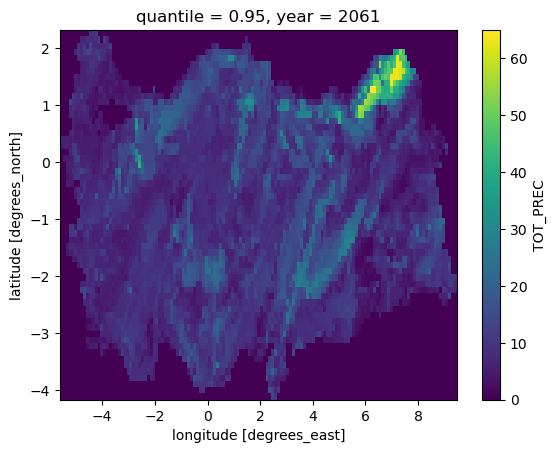

In [9]:
idx_cosmo[0].plot()

#### 2.1.2 Turkey Vector Data

In [10]:
turkey_bool = xr.open_dataset(fr"{path_save}/cosmo/BC/vectorized_turkey_mask_from_era5land.nc")

### 2.2 Clip Indice Data to Turkey

In [11]:
idx_cosmo = clip_to_turkey(idx_cosmo)
#idx_cosmo_proj_0 = clip_to_turkey(idx_cosmo_proj_0)
#idx_cosmo_proj = clip_to_turkey(idx_cosmo_proj)
#idx_cosmo_proj_all = clip_to_turkey(idx_cosmo_proj_all)

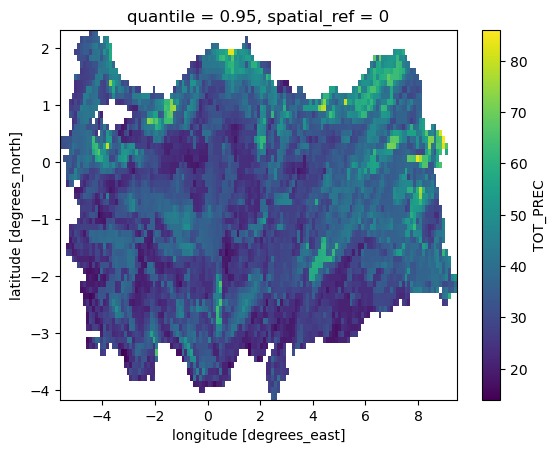

In [12]:
idx_cosmo.max(dim='year').plot()

### 2.3 Prepare Xarray Data to GEV model

In [13]:
dt_test, dt_test_pd, nonan_grids = prepare_xarray_to_gev(idx_cosmo)

In [14]:
np.shape(dt_test)

(40, 8083)

In [15]:
nonan_grids

array([  73,   74,  185, ..., 7956, 7957, 7958])

In [16]:
len(nonan_grids)

5579

In [17]:
np.shape(dt_test_pd.values)

(40, 5579)

### 2.4 GEV

#### 2.4.1 Non-stationary

In [18]:
%%time
# build a non-stationary GEV model

# introduce parameters
return_period = 20 # years
num_param = 5
num_year = np.shape(dt_test_pd)[0]
num_grid = np.shape(dt_test_pd)[1]

# in order: location, scale, shape, return_value, neg_log_likelihood
parameter_array = pd.DataFrame(index = np.arange(num_param),
                               columns = nonan_grids) # 5 for parameter space
error_array = []

# loop over grids
for grid in nonan_grids:

    # fit stationary gev model
    try:
        gev = fit_nonstationary_gev_model(dt_test_pd, 
                          grid, 
                          return_period,
                         )

        # fill in required parameters
        for param_space in range(num_param):
            parameter_array.loc[param_space, grid] = gev[param_space]
        
        # display results
        print(fr"done with grid number: {grid}")
        
    except:
        
        # report grid
        error_array.append(grid)
        
        # fill in required parameters with nan
        for param_space in range(num_param):
            parameter_array.loc[param_space, grid] = np.nan
            
        # display results
        print(fr"problem with grid number: {grid}")
        
    # display setting
    delete_last_lines(num_grid, grid)
    
# rename parameter array
parameter_array.rename(index={0:'location',
                              1:'scale',
                              2:'shape',
                              3:'return_value',
                              4:'neg_log_likelihood',
                              }, inplace=True)

CPU times: user 12min 16s, sys: 19min 26s, total: 31min 42s
Wall time: 7min 57s


##### 2.4.1.1 Recover Xarray Data

In [19]:
dt_nonstationary_recover_unstack = nonstationary_pd_to_xr(dt_test, parameter_array)

In [20]:
dt_nonstationary_recover_unstack

<xarray.Dataset>
Dimensions:             (rlat: 59, rlon: 137)
Coordinates:
    lon                 (rlat, rlon) float32 26.18 26.31 26.45 ... 45.47 45.62
    lat                 (rlat, rlon) float32 35.68 35.69 35.69 ... 41.62 41.6
    quantile            float64 0.95
    year                int64 2061
    spatial_ref         int64 ...
  * rlat                (rlat) float64 -4.11 -4.0 -3.89 -3.78 ... 2.05 2.16 2.27
  * rlon                (rlon) float64 -5.55 -5.44 -5.33 -5.22 ... 9.19 9.3 9.41
Data variables:
    return_value        (rlat, rlon) float64 nan nan nan nan ... nan nan nan nan
    location            (rlat, rlon) float64 nan nan nan nan ... nan nan nan nan
    scale               (rlat, rlon) float64 nan nan nan nan ... nan nan nan nan
    shape               (rlat, rlon) float64 nan nan nan nan ... nan nan nan nan
    neg_log_likelihood  (rlat, rlon) float64 nan nan nan nan ... nan nan nan nan

In [ ]:
# save as nonstationary 
dt_recover_unstack.to_netcdf(fr"{path_save}/cosmo/BC/GEV/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_GEV_nonstationary_{return_period}_proj_all.nc")

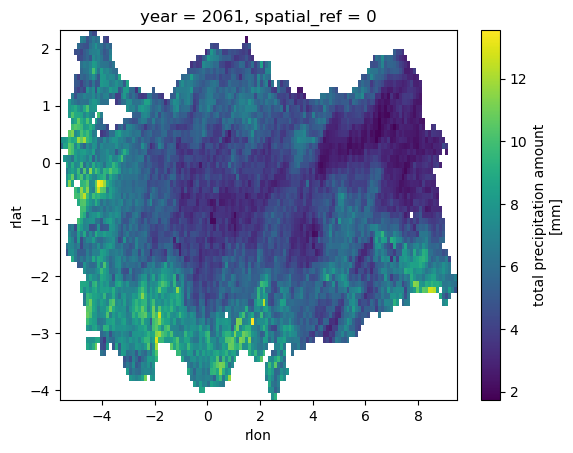

In [25]:
# with intensity
dt_nonstationary_recover_unstack['return_value'].plot()

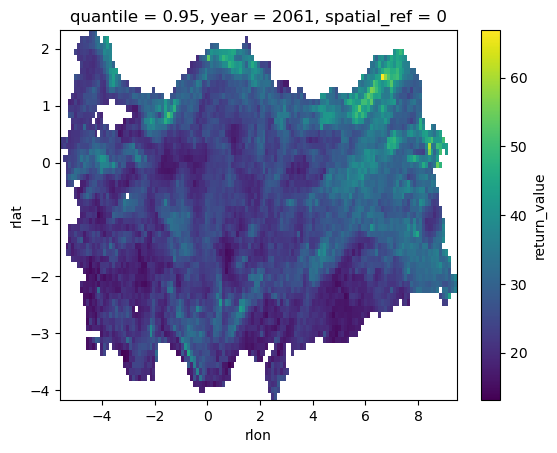

In [21]:
# with pers-perc
dt_nonstationary_recover_unstack['return_value'].plot()

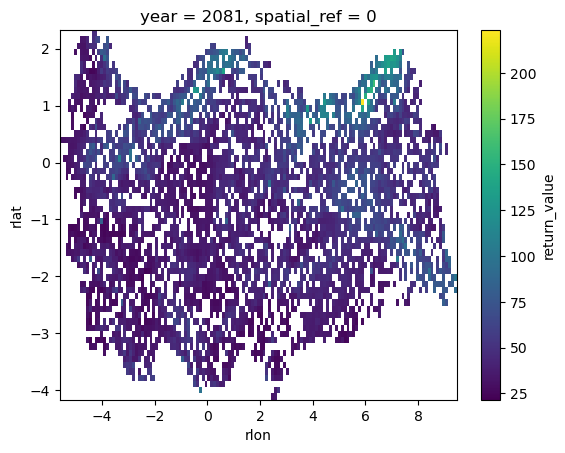

In [55]:
dt_nonstationary_recover_unstack['return_value'].plot()

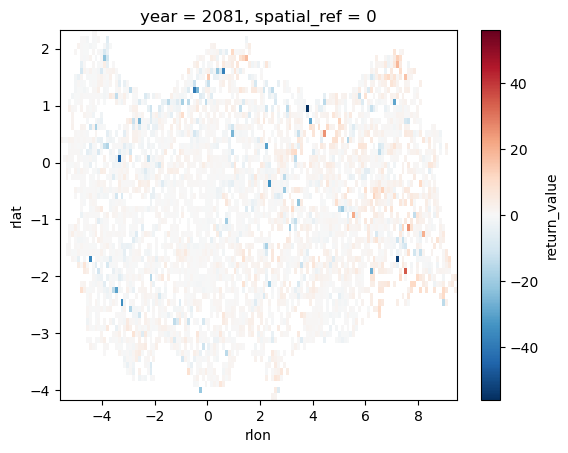

In [103]:
(dt_recover_unstack['return_value'] - dt_nonstationary_recover_unstack['return_value']).plot()

In [185]:
jk = dt_test_pd.loc[:, 323].values

In [186]:
jk

array([22., 23., 48., 25., 25., 22., 24., 16., 24., 34., 17., 16., 13.,
       27., 19., 24., 20., 12., 35., 22.])

# df

dict_ = {
    'data':jk,
    'data2':jk,
    'years':years
}

llk = pd.DataFrame(dict_)

llk['years'] = llk['years'].astype(int)

In [27]:
import scipy.io
dt_test_pd = dt_test_pd.astype(np.float64)
dt_test_pd = dt_test_pd.round(2)

In [28]:
dt_test_pd

,73,74,185,186,209,210,211,212,320,321,...,7820,7821,7822,7824,7825,7873,7956,7957,7958,years
0,6.64,6.34,9.59,8.96,5.17,4.72,2.99,4.01,7.50,7.09,...,6.13,5.87,5.43,3.89,3.65,1.87,3.69,3.08,3.35,2081.0
1,8.79,9.96,9.85,8.43,5.40,4.84,6.07,4.77,6.67,4.59,...,6.80,5.20,5.52,5.07,4.13,0.98,3.32,3.51,4.21,2082.0
2,4.27,6.67,4.49,3.91,4.95,5.65,3.49,3.40,2.97,2.89,...,2.07,2.33,2.41,2.41,2.38,1.23,1.60,1.49,1.53,2083.0
3,3.04,2.74,5.01,5.17,1.98,2.76,1.92,2.39,4.28,3.04,...,2.55,2.68,2.76,1.85,1.64,1.49,3.34,1.73,2.04,2084.0
4,3.59,2.73,3.73,2.98,3.20,2.66,1.64,3.37,4.62,4.80,...,3.22,3.36,2.88,3.00,2.43,1.69,1.41,1.44,2.00,2085.0
5,1.40,2.02,2.92,3.03,1.89,2.06,1.81,1.52,6.83,5.53,...,4.52,2.44,3.77,2.07,2.04,2.17,4.96,3.67,2.59,2086.0
6,7.59,11.94,8.68,5.02,11.64,12.93,7.76,9.09,6.47,3.33,...,2.48,2.97,2.89,2.63,2.13,1.12,1.68,1.75,2.14,2087.0
7,4.27,3.43,2.57,2.22,1.86,2.77,3.31,2.85,3.26,2.30,...,3.67,3.63,3.21,2.22,1.96,1.56,3.01,2.52,2.60,2088.0
8,3.02,4.20,4.76,2.71,3.68,3.36,2.98,2.64,3.12,4.08,...,2.78,2.86,3.44,2.94,1.87,2.32,1.96,1.78,1.74,2089.0
9,4.06,4.59,3.76,2.90,4.09,5.09,3.45,3.40,3.14,3.00,...,5.48,6.47,7.29,4.63,4.70,2.24,6.41,5.31,5.69,2090.0


In [29]:
dt_test_pd['years'] = years
dt_test_pd['years'] = dt_test_pd['years'].astype(int)

In [30]:
dt_test_pd

,73,74,185,186,209,210,211,212,320,321,...,7820,7821,7822,7824,7825,7873,7956,7957,7958,years
0,6.64,6.34,9.59,8.96,5.17,4.72,2.99,4.01,7.50,7.09,...,6.13,5.87,5.43,3.89,3.65,1.87,3.69,3.08,3.35,2081
1,8.79,9.96,9.85,8.43,5.40,4.84,6.07,4.77,6.67,4.59,...,6.80,5.20,5.52,5.07,4.13,0.98,3.32,3.51,4.21,2082
2,4.27,6.67,4.49,3.91,4.95,5.65,3.49,3.40,2.97,2.89,...,2.07,2.33,2.41,2.41,2.38,1.23,1.60,1.49,1.53,2083
3,3.04,2.74,5.01,5.17,1.98,2.76,1.92,2.39,4.28,3.04,...,2.55,2.68,2.76,1.85,1.64,1.49,3.34,1.73,2.04,2084
4,3.59,2.73,3.73,2.98,3.20,2.66,1.64,3.37,4.62,4.80,...,3.22,3.36,2.88,3.00,2.43,1.69,1.41,1.44,2.00,2085
5,1.40,2.02,2.92,3.03,1.89,2.06,1.81,1.52,6.83,5.53,...,4.52,2.44,3.77,2.07,2.04,2.17,4.96,3.67,2.59,2086
6,7.59,11.94,8.68,5.02,11.64,12.93,7.76,9.09,6.47,3.33,...,2.48,2.97,2.89,2.63,2.13,1.12,1.68,1.75,2.14,2087
7,4.27,3.43,2.57,2.22,1.86,2.77,3.31,2.85,3.26,2.30,...,3.67,3.63,3.21,2.22,1.96,1.56,3.01,2.52,2.60,2088
8,3.02,4.20,4.76,2.71,3.68,3.36,2.98,2.64,3.12,4.08,...,2.78,2.86,3.44,2.94,1.87,2.32,1.96,1.78,1.74,2089
9,4.06,4.59,3.76,2.90,4.09,5.09,3.45,3.40,3.14,3.00,...,5.48,6.47,7.29,4.63,4.70,2.24,6.41,5.31,5.69,2090


In [31]:
dt_test_pd.to_csv(fr'/mnt/c/Users/USER/Downloads/NEVA/NEVA/NEVA_GEV/readData/si1.txt', index=False, header=False, sep='\t')

In [420]:
dt_test_pd['years']

0     2081
1     2082
2     2083
3     2084
4     2085
5     2086
6     2087
7     2088
8     2089
9     2090
10    2091
11    2092
12    2093
13    2094
14    2095
15    2096
16    2097
17    2098
18    2099
19    2100
Name: years, dtype: int64

In [401]:
sample_run = scipy.io.loadmat(fr'/mnt/c/Users/USER/Downloads/NEVA/NEVA/NEVA_GEV/saveData/median_return_nonstat3.mat')

In [402]:
sample_run

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Mar 29 14:01:39 2023',
 '__version__': '1.0',
 '__globals__': [],
 'median_return': array([[ 29.12884809,  34.48557579,  39.36750378,  43.96971039,
          48.37415074,  52.62636352,  56.75536716,  60.7812515 ,
          64.71872788,  68.57901699,  72.37094681,  76.101635  ,
          79.77693518,  83.40174123,  86.98020155,  90.51587447,
          94.01184355,  97.47080483, 100.89513419]])}

In [ ]:
mnt/c/Users/USER/Downloads/NEVA/NEVA/NEVA_GEV/readData/

In [391]:
dt_test_pd

,73,74,185,186,209,210,211,212,320,321,...,7820,7821,7822,7824,7825,7873,7956,7957,7958,years
0,30.0,23.0,37.0,33.0,47.0,32.0,44.0,24.0,38.0,29.0,...,28.0,31.0,64.0,83.0,73.0,33.0,18.0,21.0,21.0,2081
1,26.0,20.0,57.0,51.0,29.0,26.0,26.0,35.0,56.0,30.0,...,22.0,32.0,38.0,38.0,37.0,23.0,30.0,25.0,27.0,2082
2,37.0,36.0,72.0,54.0,48.0,45.0,23.0,21.0,61.0,50.0,...,26.0,30.0,31.0,34.0,28.0,26.0,17.0,17.0,29.0,2083
3,22.0,23.0,26.0,25.0,30.0,30.0,23.0,22.0,21.0,21.0,...,21.0,60.0,64.0,46.0,33.0,25.0,20.0,20.0,21.0,2084
4,21.0,20.0,35.0,31.0,43.0,21.0,18.0,12.0,31.0,31.0,...,19.0,22.0,22.0,29.0,31.0,43.0,21.0,22.0,21.0,2085
5,23.0,15.0,24.0,24.0,23.0,28.0,20.0,12.0,25.0,22.0,...,14.0,14.0,18.0,75.0,56.0,19.0,12.0,12.0,13.0,2086
6,22.0,31.0,25.0,20.0,35.0,33.0,30.0,46.0,22.0,20.0,...,54.0,52.0,36.0,37.0,28.0,26.0,45.0,54.0,55.0,2087
7,12.0,13.0,23.0,14.0,10.0,14.0,13.0,12.0,10.0,19.0,...,24.0,19.0,19.0,25.0,24.0,24.0,22.0,27.0,37.0,2088
8,17.0,18.0,33.0,33.0,26.0,19.0,19.0,18.0,29.0,33.0,...,43.0,40.0,44.0,44.0,47.0,29.0,37.0,37.0,42.0,2089
9,18.0,15.0,32.0,36.0,46.0,30.0,19.0,9.0,37.0,28.0,...,39.0,43.0,43.0,36.0,38.0,17.0,50.0,49.0,47.0,2090


In [383]:
dt_test_pd['years'] = years

In [367]:
np.savetxt(fr'../deneme.txt', llk.values)

In [379]:
import scipy.io
mat = scipy.io.loadmat(fr'../median_return_stat1.mat')

In [380]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'median_return'])

In [381]:
mat['median_return']

array([[21.93679434, 25.18993863, 27.30817803, 28.89468562, 30.16779831,
        31.23309556, 32.15007576, 32.9556998 , 33.67454858, 34.32381939,
        34.91602543, 35.46056158, 35.96466473, 36.43402996, 36.87322095,
        37.28595203, 37.67528735, 38.04378469, 38.39360162, 38.72657508,
        39.04428212, 39.34808689, 39.63917739, 39.91859467, 40.18725619,
        40.44597466, 40.69547347, 40.93639939, 41.16933298, 41.39479744,
        41.61326587, 41.82516757, 42.03089321, 42.23079944, 42.42521265,
        42.61443239, 42.79873417, 42.97837204, 43.15358071, 43.32457752,
        43.4915641 , 43.65472782, 43.81424316, 43.97027285, 44.12296889,
        44.2724735 , 44.41891991, 44.56243316, 44.70313069, 44.84112301,
        44.9765142 , 45.1094024 , 45.23988027, 45.36803539, 45.49395061,
        45.61770442, 45.73937121, 45.85902157, 45.97672255, 46.0925379 ,
        46.20652826, 46.31875136, 46.42926226, 46.53811342, 46.64535494,
        46.75103467, 46.85519832, 46.95788965, 47.0

In [ ]:
100 - 2)

In [331]:
mat['nonsmp1'].max()

26.423652223782884

In [ ]:
% save median of return period
        %median_return(si)= median(mem(2:tt,1:nsamples),2);
        %fOut2= sprintf('median_return%d.mat',si);
        %save(fullfile(dirr,'saveData',fOut2),'median_return');
        %save(fOut2,'median_return');

In [333]:
np.shape(mat['nonsmp1'])

(5005, 4)

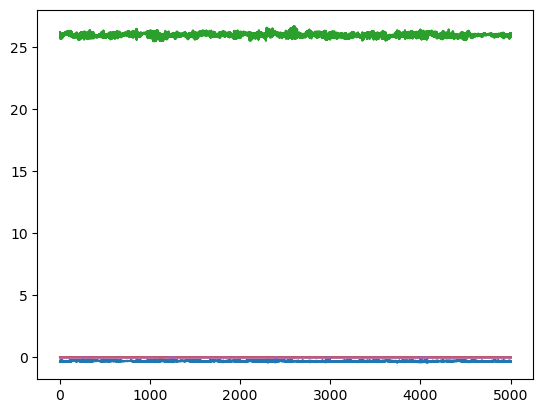

In [325]:
# parameters with including time varying parameters
plt.plot(mat['para5'])

In [176]:
np.median(mat['OUT']['RLeff'][0][0], axis=1)

array([18.73150898, 29.83505547, 35.50115725, 39.72924911, 43.94700509])

In [179]:
fit_nonstationary_gev_model(dt_test_pd, 323, return_period)

R[write to console]: Warning in (function (y, x = NULL, locationFun = NULL, scaleFun = NULL,  :
R[write to console]: 
 
R[write to console]:  fit_gev: optimization failed; see 'info' in returned object. You may want to run 'fit_gev()' with argument 'getFit = TRUE' to see more details regarding the attempted optimization. You may also want to try a different optimization method or increase the maximum number of iterations.



KeyError: 'mle'

In [49]:
fit_nonstationary_gev_model(dt_test_pd, 7507, return_period)

(356.54090056746037,
 -0.0024936937223517465,
 112.64518601446862,
 93.21504135580834,
 2.082947596659595)

## Extra

In [74]:
from pyextremes import EVA
import scipy

In [17]:
idx_cosmo.year

<xarray.DataArray 'year' (year: 21)>
array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005])
Coordinates:
    quantile     float64 0.95
  * year         (year) int64 1985 1986 1987 1988 1989 ... 2002 2003 2004 2005
    spatial_ref  int64 ...

In [112]:
dates = [pd.to_datetime(str(y)) for y in idx_cosmo.year.values]

In [113]:
dates

[Timestamp('1985-01-01 00:00:00'),
 Timestamp('1986-01-01 00:00:00'),
 Timestamp('1987-01-01 00:00:00'),
 Timestamp('1988-01-01 00:00:00'),
 Timestamp('1989-01-01 00:00:00'),
 Timestamp('1990-01-01 00:00:00'),
 Timestamp('1991-01-01 00:00:00'),
 Timestamp('1992-01-01 00:00:00'),
 Timestamp('1993-01-01 00:00:00'),
 Timestamp('1994-01-01 00:00:00'),
 Timestamp('1995-01-01 00:00:00'),
 Timestamp('1996-01-01 00:00:00'),
 Timestamp('1997-01-01 00:00:00'),
 Timestamp('1998-01-01 00:00:00'),
 Timestamp('1999-01-01 00:00:00'),
 Timestamp('2000-01-01 00:00:00'),
 Timestamp('2001-01-01 00:00:00'),
 Timestamp('2002-01-01 00:00:00'),
 Timestamp('2003-01-01 00:00:00'),
 Timestamp('2004-01-01 00:00:00'),
 Timestamp('2005-01-01 00:00:00')]

In [109]:
pd.to_datetime('1992')

Timestamp('1992-01-01 00:00:00')

In [100]:
dates

[datetime.datetime(1985, 12, 31, 0, 0),
 datetime.datetime(1986, 12, 31, 0, 0),
 datetime.datetime(1987, 12, 31, 0, 0),
 datetime.datetime(1988, 12, 31, 0, 0),
 datetime.datetime(1989, 12, 31, 0, 0),
 datetime.datetime(1990, 12, 31, 0, 0),
 datetime.datetime(1991, 12, 31, 0, 0),
 datetime.datetime(1992, 12, 31, 0, 0),
 datetime.datetime(1993, 12, 31, 0, 0),
 datetime.datetime(1994, 12, 31, 0, 0),
 datetime.datetime(1995, 12, 31, 0, 0),
 datetime.datetime(1996, 12, 31, 0, 0),
 datetime.datetime(1997, 12, 31, 0, 0),
 datetime.datetime(1998, 12, 31, 0, 0),
 datetime.datetime(1999, 12, 31, 0, 0),
 datetime.datetime(2000, 12, 31, 0, 0),
 datetime.datetime(2001, 12, 31, 0, 0),
 datetime.datetime(2002, 12, 31, 0, 0),
 datetime.datetime(2003, 12, 31, 0, 0),
 datetime.datetime(2004, 12, 31, 0, 0),
 datetime.datetime(2005, 12, 31, 0, 0)]

In [121]:
hg = dt_test_pd.loc[:,7508].values
model = EVA(pd.Series(hg, index=dates))

In [122]:
model.get_extremes(method="BM", block_size="1Y", errors="coerce")

365.2425D

In [123]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                                  21
Start:                       January 1985      End:                         January 2005
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 21      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

In [124]:
model.fit_model(distribution = 'genextreme')

In [125]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                                  21
Start:                       January 1985      End:                         January 2005
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 21      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [126]:
summary = model.get_summary(
    return_period=[20],
    alpha=0.95,
    n_samples=10,
)

In [127]:
summary

,return value,lower ci,upper ci
return period,,,
20.0,257.331437,244.666368,1.275773e+08


In [92]:
hg

array([ 46., 248., 221., 264., 142., 169.,  47.,  36., 174.,  56.,  31.,
        47.,  54., 177., 174.,  23.,  66., 232.,  39.,  40.,  33.])

In [93]:
from scipy.stats import genextreme as gev

In [98]:
# first four moments
gev.fit(hg, method='MLE')

(-0.8416017304467177, 51.77134705791294, 34.54342644059123)

In [95]:
mean

array([-1.19622221e+056,             -inf,             -inf,
                   -inf, -1.89814376e+243, -2.52607574e+302,
       -5.50262216e+057, -1.03331480e+040,             -inf,
       -1.26964034e+073, -2.65252860e+032, -5.50262216e+057,
       -4.27488328e+069,             -inf,             -inf,
       -1.12400073e+021, -8.24765059e+090,             -inf,
       -5.23022617e+044, -2.03978821e+046, -2.63130837e+035])

In [64]:
shape, loc, scale = gev.fit(hg)
l = loc + scale / shape
xx = np.linspace(l+0.00001, l+0.00001+35, num=71)
yy = gev.pdf(xx, shape, loc, scale)

In [66]:
l

10.726485586138438

In [67]:
xx

array([10.72649559, 11.22649559, 11.72649559, 12.22649559, 12.72649559,
       13.22649559, 13.72649559, 14.22649559, 14.72649559, 15.22649559,
       15.72649559, 16.22649559, 16.72649559, 17.22649559, 17.72649559,
       18.22649559, 18.72649559, 19.22649559, 19.72649559, 20.22649559,
       20.72649559, 21.22649559, 21.72649559, 22.22649559, 22.72649559,
       23.22649559, 23.72649559, 24.22649559, 24.72649559, 25.22649559,
       25.72649559, 26.22649559, 26.72649559, 27.22649559, 27.72649559,
       28.22649559, 28.72649559, 29.22649559, 29.72649559, 30.22649559,
       30.72649559, 31.22649559, 31.72649559, 32.22649559, 32.72649559,
       33.22649559, 33.72649559, 34.22649559, 34.72649559, 35.22649559,
       35.72649559, 36.22649559, 36.72649559, 37.22649559, 37.72649559,
       38.22649559, 38.72649559, 39.22649559, 39.72649559, 40.22649559,
       40.72649559, 41.22649559, 41.72649559, 42.22649559, 42.72649559,
       43.22649559, 43.72649559, 44.22649559, 44.72649559, 45.22

In [128]:
jh = climextremes.fit_gev(y=hg,
                                           returnPeriod = 20,
                                           getParams = True,
                                           getFit = True,
                                           #optimArgs = {'method': 'BFGS'},
                                           #bootSE = True
                                             )

In [49]:
hg

array([ 46., 248., 221., 264., 142., 169.,  47.,  36., 174.,  56.,  31.,
        47.,  54., 177., 174.,  23.,  66., 232.,  39.,  40.,  33.])

In [ ]:
idx_cosmo.year.values

In [129]:
jh

{'mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'mle': array([51.76913963, 34.5439336 ,  0.84187169]),
 'se_mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'se_mle': array([ 8.86510247, 10.61848008,  0.28683686]),
 'nllh': array([117.04107786]),
 'returnValue': array([510.87426079]),
 'se_returnValue': array([325.66544595]),
 'info': {'convergence': array([0], dtype=int32),
  'counts_names': array(['function', 'gradient'], dtype='<U8'),
  'counts': array([148.,  nan]),
  'message': None,
  'failure': array([0], dtype=int32)},
 'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
  'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
  'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]),
  'in.data': array([1], dtype=int32),
  'x.fun': None,
  'missing.values_names': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
         

In [71]:
np.array([[1,2,3],
         [4,5,6]]).transpose().flatten()

array([1, 4, 2, 5, 3, 6])

In [91]:
mm = pd.DataFrame(index = np.arange(num_param),
                               columns = nonan_grids)

In [92]:
mm

,73,74,185,186,209,210,211,212,320,321,...,7819,7820,7821,7822,7824,7825,7873,7956,7957,7958
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
climextremes.fit_gev(y=dt_test_pd.loc[:, 5646].values,
                                           returnPeriod = 20,
                                           getParams = True,
                                           getFit = True,
                                           #optimArgs = {'method': 'BFGS'}
                                             )

{'mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'mle': array([6.73406947, 0.98548034, 1.12758159]),
 'se_mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'se_mle': array([0.28419705, 0.37703893, 0.42845421]),
 'nllh': array([44.95784791]),
 'returnValue': array([30.74934843]),
 'se_returnValue': array([23.93894095]),
 'info': {'convergence': array([0], dtype=int32),
  'counts_names': array(['function', 'gradient'], dtype='<U8'),
  'counts': array([104.,  nan]),
  'message': None,
  'failure': array([0], dtype=int32)},
 'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
  'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
  'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]),
  'in.data': array([1], dtype=int32),
  'x.fun': None,
  'missing.values_names': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
         '13', '14

In [48]:
climextremes.calc_riskRatio_gev(returnValue=0.2,
                                y1 = dt_test_pd.loc[:, 185].values,
                                y2 = dt_test_pd.loc[:, 185].values,
                                optimArgs = {'method': 'BFGS'},
                                ciType = 'lrt',
                                getFit = True)

{'logRiskRatio': array([0.]),
 'se_logRiskRatio': array([0.09414298]),
 'riskRatio': array([1.]),
 'ci_riskRatio_lrt_names': array(['0.05', '0.95'], dtype='<U4'),
 'ci_riskRatio_lrt': array([0.87718788, 1.18652614]),
 'fit1': {'info': {'convergence': array([0], dtype=int32),
   'counts_names': array(['function', 'gradient'], dtype='<U8'),
   'counts': array([25,  7], dtype=int32),
   'message': None,
   'failure': array([0], dtype=int32)},
  'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
   'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
   'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]),
   'in.data': array([1], dtype=int32),
   'x.fun': None,
   'missing.values_names': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
          '13', '14', '15', '16', '17', '18', '19', '20', '21'], dtype='<U2'),
   'missing.values': array([0, 0, 0, 0, 0, 0, 0

In [28]:
gev = fit_stationary_gev_model(dt_test_pd, 
                          1748, 
                          20,
                         )

In [32]:
gev[1]

{'mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'mle': array([ 0.33997986,  0.21525492, -0.19574744]),
 'se_mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'se_mle': array([0.05172092, 0.03570991, 0.12848844]),
 'nllh': array([-1.58398401]),
 'returnValue': array([0.8248068]),
 'se_returnValue': array([0.08706329]),
 'info': {'convergence': array([0], dtype=int32),
  'counts_names': array(['function', 'gradient'], dtype='<U8'),
  'counts': array([98., nan]),
  'message': None,
  'failure': array([0], dtype=int32)},
 'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
  'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
  'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]),
  'in.data': array([1], dtype=int32),
  'x.fun': None,
  'missing.values_names': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
         '13', '14',

In [35]:
inverse_transform_gev_data(gev[0], -1.58398401)

-3.0657933853288

In [30]:
gev[0].inverse_transform()

MinMaxScaler()

In [22]:
dt_test_pd

,73,74,185,186,209,210,211,212,320,321,...,7819,7820,7821,7822,7824,7825,7873,7956,7957,7958
0,4.682993,4.581517,5.954436,4.271856,3.104824,4.030866,2.578392,1.904314,4.662383,4.683877,...,1.945353,2.316870,2.408273,3.538940,3.837317,3.029725,1.798070,1.760897,1.522017,1.630583
1,5.231761,5.561224,2.765930,3.143718,3.525167,5.200108,3.513677,4.003284,3.729662,3.239053,...,2.734778,3.510003,2.666895,2.845000,1.738426,1.663888,1.082482,2.061790,2.165333,3.134095
2,6.258524,5.174025,3.785212,5.678714,6.648182,6.071765,6.543147,3.654497,5.780795,4.066742,...,3.057394,3.786375,3.542936,3.873625,2.413285,2.170086,1.301293,2.440294,2.511733,3.049181
3,3.879579,4.268241,2.965338,3.115246,3.230245,2.891891,3.244194,4.161205,4.508462,3.716793,...,3.803394,2.814263,2.662900,2.871493,1.779875,1.778119,0.962230,3.264480,1.956327,1.804569
4,5.583479,5.395182,3.464232,3.645400,6.690164,3.905880,3.777098,4.167530,4.524528,3.455562,...,1.919903,1.945517,2.693727,3.840880,4.415148,3.950884,1.035412,2.271008,1.955406,2.354686
5,3.892350,3.877173,3.919154,3.236011,3.708644,3.369156,1.856075,2.636142,4.173568,3.160882,...,2.072290,2.064853,1.927692,2.187586,1.620923,1.656478,1.953081,1.789136,1.451546,1.623468
6,7.482260,6.906573,4.964650,4.756420,4.375335,5.970234,5.097263,5.950561,3.894535,3.876056,...,3.155958,3.006989,3.489330,4.190116,3.462429,3.126924,1.076934,2.624151,2.852860,2.495729
7,6.076189,6.216465,4.371316,4.251369,7.083550,7.219672,4.202714,4.191990,4.745814,4.337898,...,3.539624,2.636261,3.145139,3.009133,2.019802,1.494784,1.442931,3.616986,1.879787,2.326417
8,5.953750,5.375830,4.716165,4.868830,4.593935,4.292323,3.715103,2.982358,3.828084,4.678486,...,1.741966,2.364587,2.489920,2.337821,1.812633,1.629757,1.115311,1.675950,1.720810,1.777671
9,3.797640,4.115176,6.100320,6.720867,4.096058,3.154917,2.293610,3.272298,6.334043,6.545190,...,2.204201,2.308447,2.623501,2.769658,2.749326,1.831479,1.238635,2.369585,1.983810,2.486889


In [18]:
parameter_array

,73,74,185,186,209,210,211,212,320,321,...,7819,7820,7821,7822,7824,7825,7873,7956,7957,7958
location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return_value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neg_log_likelihood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
np.array(error_array)

array([ 571,  845,  847,  879,  980,  982, 1027, 1105, 1106, 1107, 1108,
       1242, 1243, 1398, 1517, 1664, 1668, 1672, 1673, 1800, 1804, 1808,
       1938, 1939, 2072, 2073, 2077, 2079, 2082, 2207, 2210, 2213, 2214,
       2216, 2217, 2347, 2348, 2350, 2354, 2361, 2371, 2403, 2404, 2486,
       2505, 2506, 2626, 2627, 2643, 2644, 2678, 2748, 2749, 2759, 2760,
       2761, 2762, 2764, 2805, 2816, 2898, 2899, 2900, 2901, 2903, 2910,
       2953, 3011, 3034, 3035, 3036, 3037, 3038, 3039, 3047, 3063, 3162,
       3170, 3173, 3174, 3175, 3176, 3182, 3200, 3201, 3297, 3298, 3299,
       3307, 3309, 3310, 3311, 3312, 3313, 3315, 3318, 3319, 3321, 3322,
       3365, 3443, 3449, 3450, 3451, 3452, 3458, 3459, 3476, 3571, 3586,
       3591, 3596, 3609, 3726, 3730, 3734, 3747, 3755, 3871, 3872, 3884,
       3885, 3891, 3892, 3995, 4013, 4024, 4028, 4147, 4148, 4161, 4305,
       4429, 4567, 4574, 4577, 4578, 4702, 4704, 4705, 4706, 4711, 4712,
       4713, 4835, 4838, 4840, 4841, 4842, 4849, 48

In [20]:
dt_test_pd.loc[:, 7507].values

array([119., 119.,  85., 112.,  93., 142., 133., 166.,  85.,  76., 274.,
       124., 131.,  87., 107., 133.,  99.,  40.,  31.,  16., 102.])

In [64]:
from sklearn.preprocessing import MinMaxScaler
hg = dt_test_pd.loc[:,7507].values.reshape(-1, 1)
mhj_fit = MinMaxScaler().fit(hg)
mhj_transform = mhj_fit.transform(hg)
mhj = mhj_transform.ravel()

In [17]:
dt_test_pd.loc[:,7508].values#.reshape(-1, 1)

array([108., 121.,  89., 122.,  85., 140., 123., 164.,  83.,  20., 228.,
       141., 132.,  90., 101., 129., 113.,  23., 116.,  17., 129.])

In [121]:
mhj_fit.inverse_transform(np.array([1.51765659]).reshape(-1, 1))

array([[186.83210454]])

In [65]:
hg.ravel()

array([119., 119.,  85., 112.,  93., 142., 133., 166.,  85.,  76., 274.,
       124., 131.,  87., 107., 133.,  99.,  40.,  31.,  16., 102.])

In [80]:
# normal
hg = dt_test_pd.loc[:,7306].values

In [83]:
# scale
hg = dt_test_pd.loc[:,7306].values.reshape(-1, 1)
hg_fit = MinMaxScaler().fit(hg)
hg = hg_fit.transform(hg)
hg = hg.ravel()

In [86]:
hg_fit.inverse_transform(np.array([0.94947955]).reshape(-1, 1))

array([[164.1188098]])

In [90]:
hg_fit.inverse_transform(np.array([0.94947955]).reshape(-1, 1))[0][0]

164.1188098

In [87]:
hg

array([1.        , 0.67307692, 0.62179487, 0.95512821, 0.69871795,
       0.6474359 , 0.87179487, 0.66666667, 0.6025641 , 0.        ,
       0.66666667, 0.69230769, 0.57051282, 0.18589744, 0.83974359,
       0.54487179, 0.3974359 , 0.76923077, 0.75641026, 0.10897436,
       0.15384615])

In [84]:
jh = climextremes.fit_gev(y=hg,
                                           returnPeriod = 20,
                                           getParams = True,
                                           getFit = True,
                                           #optimArgs = {'method': 'BFGS'},
                                           #scaling = float(np.max(hg))
                                           #bootSE = True
                                             )

In [85]:
jh

{'mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'mle': array([ 0.54033225,  0.29615853, -0.60317838]),
 'se_mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'se_mle': array([0.07030136, 0.05664459, 0.1574367 ]),
 'nllh': array([0.34155615]),
 'returnValue': array([0.94947955]),
 'se_returnValue': array([0.03303874]),
 'info': {'convergence': array([0], dtype=int32),
  'counts_names': array(['function', 'gradient'], dtype='<U8'),
  'counts': array([92., nan]),
  'message': None,
  'failure': array([0], dtype=int32)},
 'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
  'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
  'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]),
  'in.data': array([1], dtype=int32),
  'x.fun': None,
  'missing.values_names': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
         '13', '14',

In [55]:
jh

{'mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'mle': array([-0.20325268,  1.08902597, -0.57841156]),
 'se_mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'se_mle': array([0.25661742, 0.19927148, 0.13797364]),
 'nllh': array([27.86670462]),
 'returnValue': array([1.34171463]),
 'se_returnValue': array([0.12854028]),
 'info': {'convergence': array([0], dtype=int32),
  'counts_names': array(['function', 'gradient'], dtype='<U8'),
  'counts': array([118.,  nan]),
  'message': None,
  'failure': array([0], dtype=int32)},
 'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
  'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
  'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]),
  'in.data': array([1], dtype=int32),
  'x.fun': None,
  'missing.values_names': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
         '13', '1

In [145]:
float(hg.max())

274.0

In [147]:
jh['mle']

array([88.28041533, 46.55472632, -0.0961832 ])

In [150]:
jh['returnValue']

array([222.76221768])

In [130]:
mhj_fit.inverse_transform(np.array([0.86991644]).reshape(-1, 1))

array([[153.30828173]])

In [72]:
jh

{'mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'mle': array([-0.19026163,  1.10053238, -0.60329969]),
 'se_mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'se_mle': array([0.26123944, 0.21045011, 0.15719093]),
 'nllh': array([27.90646393]),
 'returnValue': array([1.39714331]),
 'se_returnValue': array([0.11943323]),
 'info': {'convergence': array([0], dtype=int32),
  'counts_names': array(['function', 'gradient'], dtype='<U8'),
  'counts': array([106.,  nan]),
  'message': None,
  'failure': array([0], dtype=int32)},
 'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
  'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
  'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]),
  'in.data': array([1], dtype=int32),
  'x.fun': None,
  'missing.values_names': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
         '13', '1

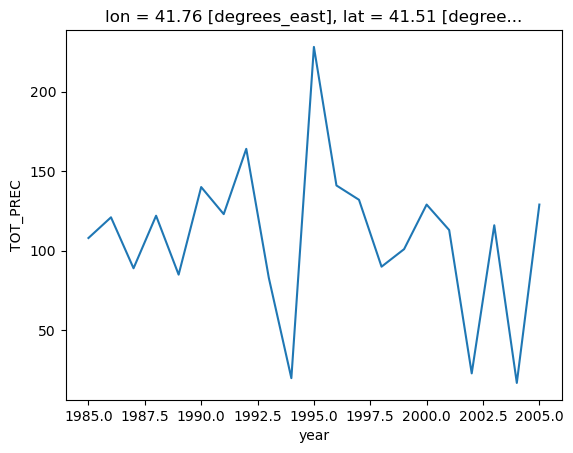

In [21]:
dt_test[:, 7508].plot()